In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


D:\anomaly-detection


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks as cf
from src.features.build_features import rolling_window
from src.models.DDRE import *

from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [33]:
def compute_ratios(y, width_candidates, params, ratio=0.3):
    print('Finding hyperparams...')
    _, optimal = kernel_width_selection(y[:int(y.shape[0]*ratio)], width_candidates, params)
    params['window_width'] = int(optimal)
    print(f'\nOptimal width is {optimal}\n')
    
    print('Starting compute ratios...')
    ratios, chng_pts = ddre_ratios_df(y, **params)
    peaks, _ = find_peaks(ratios, distance=optimal)
    
    return ratios, chng_pts, peaks

In [63]:
from bokeh.plotting import figure, output_file, show

def plot(ratios, peaks, anom_start_idxs=None, anomaly_length=None, window_width=None):
    p = figure(plot_width=800, plot_height=600, tools="xwheel_zoom,pan,box_zoom,reset")

    p.line(np.arange(ratios.shape[0]), ratios, line_width=2)
    p.scatter(peaks, ratios[peaks], fill_color="red", size=15)
    
    if anom_start_idxs is not None:
        for start_idx in anom_start_idxs[:, 0]:
            start_idx -= window_width
            r = start_idx + anomaly_length
            if start_idx < 0:
                r += start_idx
                start_idx = 0
            x = np.arange(start_idx, start_idx+anomaly_length)
            p.line(x, ratios[x], line_width=2, color="red")

    show(p)

# Artificial dataset

In [37]:
params = dict(
    sigma_candidates=[0.1, 1, 5, 10, 20, 50, 100, 1000],
    chunk_size=50,
    R=3,
    n_rf_te=32,
    verbose=False,
    build_args=dict(),
    update_args=dict(lerning_rate=1, reg_parameter=0.01)
)

## Example 1

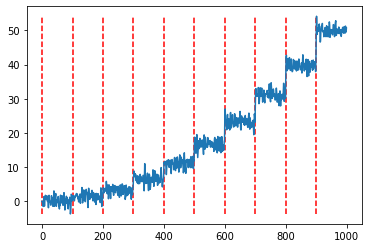

In [38]:
# Lets check algorithm on synthetic dataset
n = 1000
mean = 0
step = 100
y = np.zeros(n, dtype=float)
for i in range(2, n):
    if i % step == 0:
        mean = mean + i // step
    y[i] = y[i-1]*0.6 - y[i-2]*0.5 + mean + np.random.randn()

plt.plot(y)
plt.vlines(list(range(0, n, step)), np.min(y), np.max(y), linestyle='--', colors='r')

In [40]:
ratios, _, peaks = compute_ratios(y.reshape(-1, 1), [40, 50, 60], params)

Finding hyperparams...
Candidate 40
Finding optimal sigma...
Optimal sigma is: 5
Candidate 50
Finding optimal sigma...
Optimal sigma is: 5
Candidate 60
Finding optimal sigma...
Optimal sigma is: 5
Candidate 70
Finding optimal sigma...
Optimal sigma is: 5

Optimal width is 50

Starting compute ratios...
Finding optimal sigma...
Optimal sigma is: 5


In [41]:
plot(ratios, peaks)

In [10]:
# print(f'In given to the model dataset, point from ratios graphic correspond \
# to point in [x-{params["n_rf_te"]}, x+{
# }]')

## Example 2

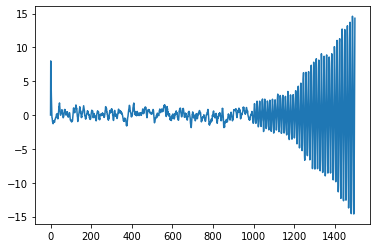

In [42]:
y = [0, 8, 6, 4]

for i in range(4, 1000):
    y.append(0.97 * y[i-1] + 0.4 * y[i - 2] - 0.5 * y[i-3] + 0.2 * np.random.randn())
for i in range(1000, 1500):
    y.append(0.97 * y[i-1] + 0.4 * y[i - 2] - 0.8 * y[i-3] + 0.2 * np.random.randn())

true_change_points = [1000]
y = np.array(y).reshape(-1,1)

plt.plot(y)

In [44]:
ratios, _, peaks = compute_ratios(y, [600, 700, 800], params, ratio=1)

Finding hyperparams...
Candidate 600
Finding optimal sigma...
Optimal sigma is: 5
Candidate 700
Finding optimal sigma...
Optimal sigma is: 5
Candidate 800
Finding optimal sigma...
Optimal sigma is: 5

Optimal width is 800

Starting compute ratios...
Finding optimal sigma...
Optimal sigma is: 5


In [45]:
plot(ratios, peaks)

## Example 3. Blending

In [46]:
x = np.linspace(0, 2, num=200)
y1 = np.sin(2 * np.pi * x)
y2 = np.sin(4 * np.pi * x)
y3 = np.sinh((x - 1) * 2)
y4 = np.cosh((x - 1) * 2)
y5 = np.exp((x - 1) * 2)

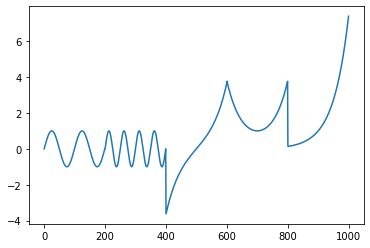

In [47]:
y = np.hstack((y1, y2, y3, y4, y5)).reshape(-1, 1)
plt.plot(y)

In [48]:
params['chunk_size'] = 25

In [51]:
ratios, _, peaks = compute_ratios(y.reshape(-1, 1), [60, 80, 100], params)

Finding hyperparams...
Candidate 60
Finding optimal sigma...
Optimal sigma is: 5
Candidate 80
Finding optimal sigma...
Optimal sigma is: 5
Candidate 100
Finding optimal sigma...
Optimal sigma is: 5

Optimal width is 80

Starting compute ratios...
Finding optimal sigma...
Optimal sigma is: 5


In [52]:
plot(ratios, peaks)

# Real data

In [27]:
data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


In [53]:
params = dict(
    window_width=100,
    sigma_candidates=[0.1, 1, 5, 10, 15, 20, 50, 100, 1000],
    chunk_size=100,
    R=4,
    n_rf_te=32,
    verbose=True,
    build_args=dict(),
    update_args=dict(lerning_rate=1, reg_parameter=0.01)
)

## Вставка change-point

### Все компоненты

In [29]:
from src.data.generate import insert_anomalies

anomalies_kwargs = dict(
    amount=30,
    axis=0,
    anomaly_length=50
)

In [30]:
changed_df, anom_start_idxs = insert_anomalies(data, **anomalies_kwargs)

In [60]:
ratios, _, peaks = compute_ratios(changed_df, [100, 200, 500], params, ratio=0.1)

Finding hyperparams...
Candidate 100
Finding optimal sigma...
Optimal sigma is: 50
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
Candidate 200
Finding optimal sigma...
Optimal sigma is: 50
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
Candidate 500
Finding optimal sigma...
Optimal sigma is: 50
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%

In [62]:
anom_start_idxs

array([[ 2387,     0],
       [12672,     0],
       [ 2839,     0],
       [ 1569,     0],
       [ 5249,     0],
       [ 2856,     0],
       [  849,     0],
       [ 1799,     0],
       [ 5132,     0],
       [10452,     0]])

In [65]:
plot(ratios, peaks, anom_start_idxs, anomalies_kwargs['anomaly_length'], params['window_width'])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



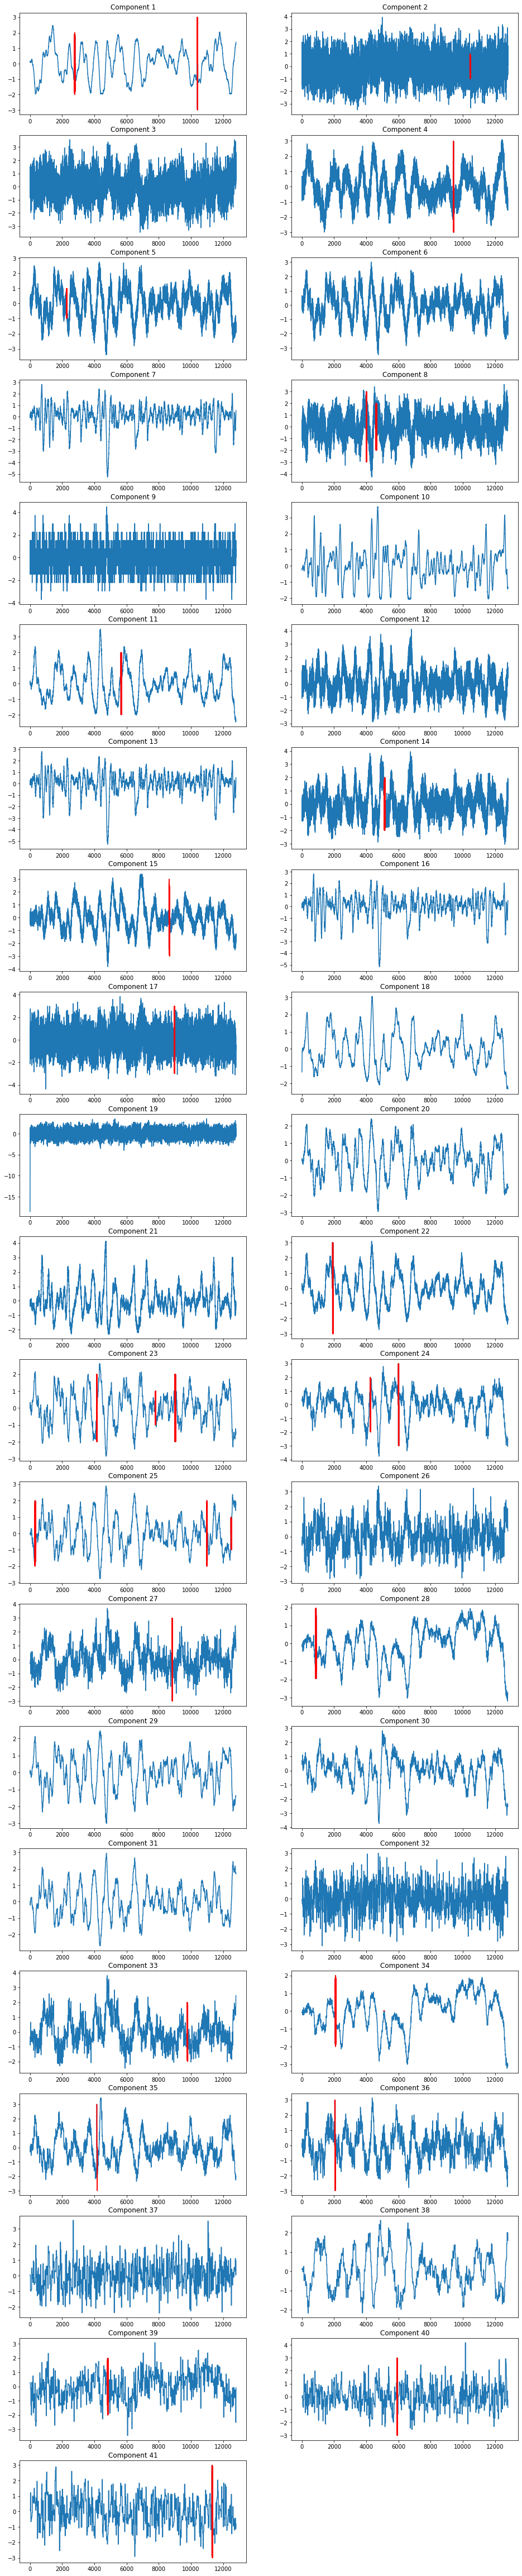

In [56]:
width, height = 8, 4
ncols = 2
nrows = 21

plt.figure(figsize=(width * ncols, height * nrows))
for i in range(changed_df.shape[1]):
    plt.subplot(nrows, ncols, i+1)
    plt.title(f'Component {i+1}')
    plt.plot(changed_df[:, i])

for start_idx in anom_start_idxs:
    i, j = start_idx
    plt.subplot(nrows, ncols, j+1)
    right = i+anomalies_kwargs['anomaly_length']
    plt.plot(np.arange(i,right),changed_df[i:right, j], c='r')

### Одна компонента

In [66]:
component = 7

rat = data[str(component)]

In [67]:
from src.data.generate import insert_anomalies

anomalies_kwargs = dict(
    amount=10,
    axis=0,
    anomaly_length=50
)

changed_rat, anom_start_idxs = insert_anomalies(rat.to_numpy().reshape(-1, 1), **anomalies_kwargs)

In [68]:
ratios, _, peaks = compute_ratios(changed_rat, [100, 150, 200, 500], params, ratio=0.3)

Finding hyperparams...
Candidate 100
Finding optimal sigma...
Optimal sigma is: 5
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
Candidate 150
Finding optimal sigma...
Optimal sigma is: 5
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%
Candidate 200
Finding optimal sigma...
Optimal sigma is: 5
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%


In [69]:
plot(ratios, peaks, anom_start_idxs, anomalies_kwargs['anomaly_length'], params['window_width'])

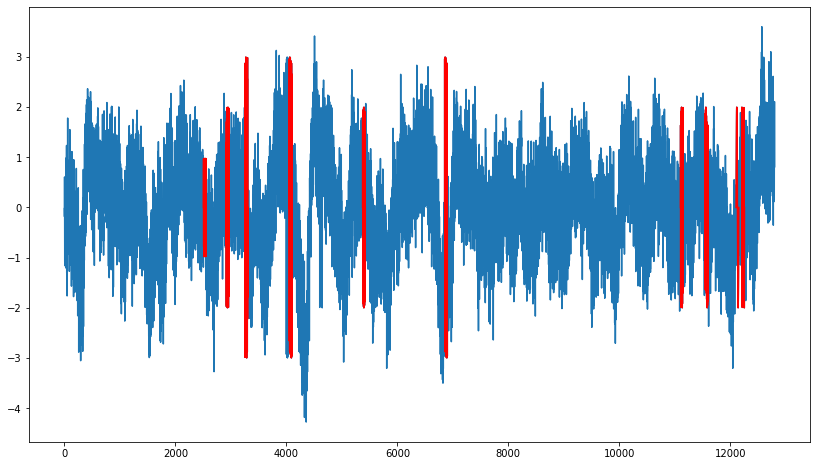

In [70]:
width, height = 14, 8

plt.figure(figsize=(width, height))

plt.plot(changed_rat)
for start_idx in anom_start_idxs:
    i, j = start_idx
    right = i+anomalies_kwargs['anomaly_length']
    plt.plot(np.arange(i,right),changed_rat[i:right, j], c='r')

## Без синусоид

In [71]:
ratios, _, peaks = compute_ratios(data, [100, 150, 200, 500], params, ratio=0.1)

Finding hyperparams...
Candidate 100
Finding optimal sigma...
Optimal sigma is: 50
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
Candidate 150
Finding optimal sigma...
Optimal sigma is: 50
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
Candidate 200
Finding optimal sigma...
Optimal sigma is: 50
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
2

In [80]:
peaks_, _ = find_peaks(ratios, distance=params['window_width'], height=21)

In [81]:
plot(ratios, peaks_)